In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [2]:
cv2.__version__

'3.1.0'

In [3]:
img1 = cv2.imread('img1.png', cv2.IMREAD_COLOR)
img2 = cv2.imread('img2.png', cv2.IMREAD_COLOR)

In [4]:
# opencv : BGR, matplotlib : RGB
b, g, r = cv2.split(img1)
img1 = cv2.merge([r, g, b])
b, g, r = cv2.split(img2)
img2 = cv2.merge([r, g, b])

In [5]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [6]:
img1_file = plt.imread('img1.png')
img2_file = plt.imread('img2.png')

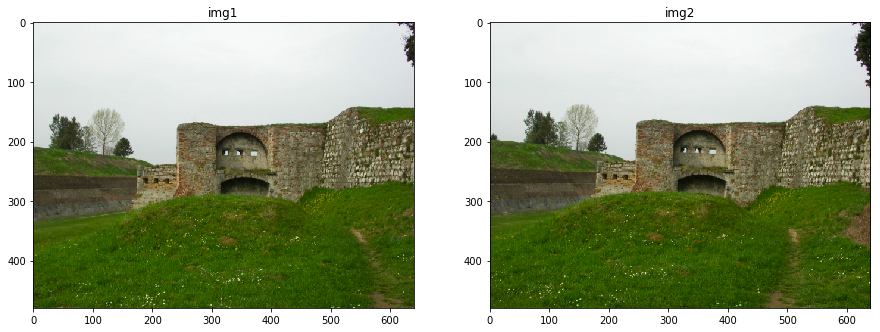

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img1)
plt.title('img1')

plt.subplot(122)
plt.imshow(img2)
plt.title('img2')
plt.show()

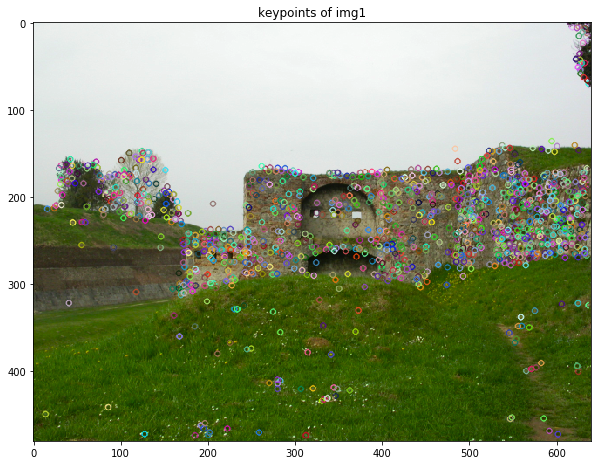

In [9]:
sift = cv2.xfeatures2d.SIFT_create()
(kp1, descs1) = sift.detectAndCompute(gray1, None)
sift_img = cv2.drawKeypoints(img1, kp1, None)

plt.figure(figsize=(10, 10))
plt.imshow(sift_img)
plt.title('keypoints of img1')
plt.show()

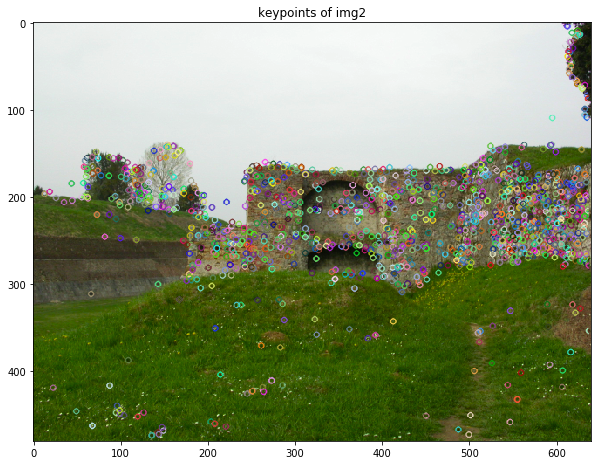

In [10]:
sift2 = cv2.xfeatures2d.SIFT_create()
(kp2, descs2) = sift.detectAndCompute(gray2, None)
sift_img2 = cv2.drawKeypoints(img2, kp2, None)

plt.figure(figsize=(10, 10))
plt.imshow(sift_img2)
plt.title('keypoints of img2')
plt.show()

In [11]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descs1, descs2, k=2)

In [12]:
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

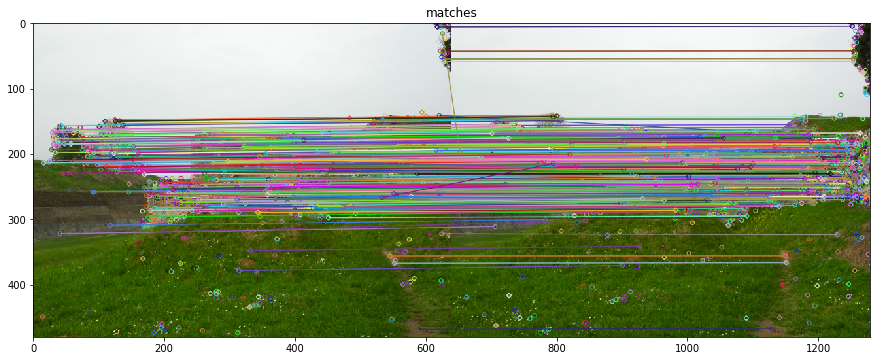

In [13]:
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good, None)
plt.figure(figsize=(15,15))
plt.imshow(img3)
plt.title('matches')
plt.show()

In [14]:
# 매칭점 인덱스 알아내기
pt = []

for i in range(11, 19):
    pt.append((good[i][0].queryIdx, good[i][0].trainIdx))


In [15]:
# 매칭점 좌표 알아내기
coordi = []

for i in range(8):
    coordi.append((np.round(kp1[pt[i][0]].pt), np.round(kp2[pt[i][1]].pt)))

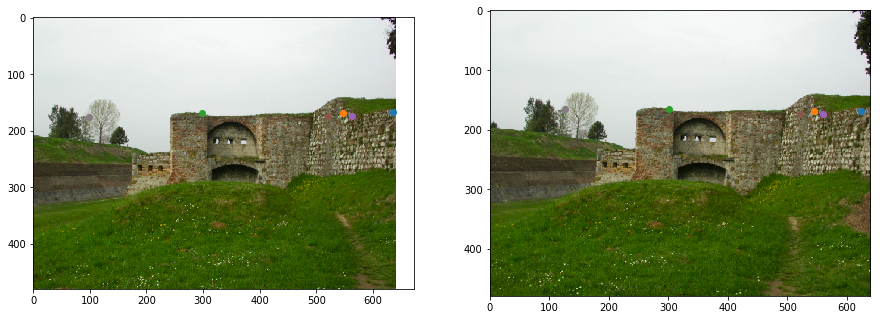

In [16]:
# 매징점 좌표 표시
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img1)
for i in range(8):
    plt.scatter(x=coordi[i][0][0], y=coordi[i][0][1])

plt.subplot(122)
plt.imshow(img2)
for i in range(8):
    plt.scatter(x=coordi[i][1][0], y=coordi[i][1][1])
plt.show()

In [17]:
# A Matrix 구하기
A = []

for i in range(8):
    A.append([coordi[i][0][0]*coordi[i][1][0], coordi[i][0][0]*coordi[i][1][1], coordi[i][0][0], coordi[i][0][1]*coordi[i][1][0], coordi[i][0][1]*coordi[i][1][1], coordi[i][0][1], coordi[i][1][0], coordi[i][1][1], 1])

In [18]:
# A 
df = pd.DataFrame(data=A)
df.style

,0,1,2,3,4,5,6,7,8
0,396875,106680,635,104375,28056,167,625,168,1
1,298115,91896,547,92105,28392,169,545,168,1
2,89698,49170,298,50869,27885,169,301,165,1
3,315840,97572,564,96880,29929,173,560,173,1
4,315840,97572,564,96880,29929,173,560,173,1
5,270920,89960,520,90654,30102,174,521,173,1
6,12348,16268,98,22050,29050,175,126,166,1
7,12348,16268,98,22050,29050,175,126,166,1


In [19]:
# SVD(A)
U, S, V = np.linalg.svd(A)

In [20]:
# 

F = V.T[:, -1]
F = np.array(F)
print(F)

[  1.43463931e-07   1.21469270e-07  -2.31152315e-03   1.02828400e-05
  -8.34480668e-06  -1.46642548e-02   3.64336579e-04   1.05961826e-02
   9.99833588e-01]


In [21]:
F = F.reshape(3, 3)
df = pd.DataFrame(data=F)
df.style

,0,1,2
0,1.43464e-07,1.21469e-07,-0.00231152
1,1.02828e-05,-8.34481e-06,-0.0146643
2,0.000364337,0.0105962,0.999834


In [22]:
# line
line = []
for i in range(8):
    line.append(np.dot(F, np.array([[coordi[i][1][0]], [coordi[i][1][1]], [1]])))

In [23]:
line= np.array(line)
line = line.reshape(8, 3)

In [24]:
# line vector

df = pd.DataFrame(data=line)
df

,0,1,2
0,-0.002201,-0.009639,3.007703
1,-0.002213,-0.010462,2.978556
2,-0.002248,-0.012946,2.857869
3,-0.002210,-0.010350,3.037002
4,-0.002210,-0.010350,3.037002
5,-0.002216,-0.010751,3.022793
6,-0.002273,-0.014754,2.804706
7,-0.002273,-0.014754,2.804706


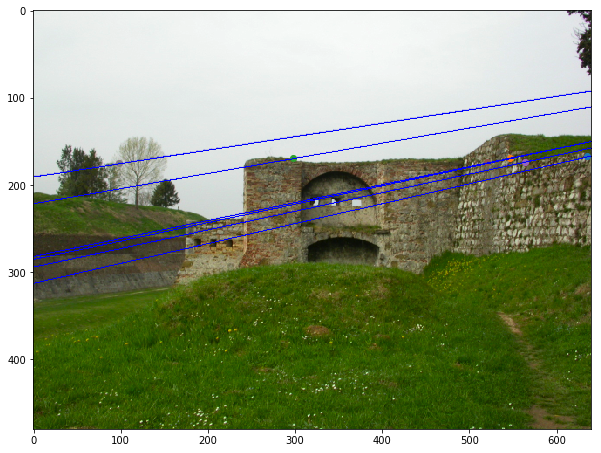

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(img1)
for i in range(8):
    plt.scatter(x=coordi[i][0][0], y=coordi[i][0][1])
    for j in range(1, 640):
        y = -(line[i][0]*j + line[i][2]) / line[i][1]
        plt.plot([j], [y], marker='1', markersize=1, color='blue')
        
plt.show()

In [26]:
np_img1 = np.zeros((3, 8))
np_img2 = np.zeros((3, 8))

for i in range(8):
    np_img1[:, i] = [coordi[i][0][0], coordi[i][0][1], 1]
    np_img2[:, i] = [coordi[i][1][0], coordi[i][1][1], 1]
    
np_img1 = np.array(np_img1)
np_img2 = np.array(np_img2)

In [27]:
# Normalized 

def normalize(pts):
    
    # centroid 구하기
    C = [np.mean(pts[0]), np.mean(pts[1])]
    print(C)
    
    new_pts = np.zeros((3, 8))
    
    # shift the origin to centroid
    new_pts[0] = pts[0] - C[0]
    new_pts[1] = pts[1] - C[1]
    
    mean_dist = np.mean(np.sqrt(np.power(new_pts[0], 2) + np.power(new_pts[1], 2)))
    print(mean_dist)
    scale = np.sqrt(2) / mean_dist
    print(scale)
    
    T = [[scale, 0, -scale*C[0]], [0, scale, -scale*C[1]], [0, 0, 1]]
    print(T)
    npts = np.dot(T, pts)
    
    return npts, T

In [28]:
npt_left, T1 = normalize(np_img1)

[415.5, 171.875]
188.147700574
0.00751650728686
[[0.0075165072868598887, 0, -3.1231087776902839], [0, 0.0075165072868598887, -1.2918996899290434], [0, 0, 1]]


In [29]:
npt_right, T2 = normalize(np_img2)

[420.5, 169.0]
177.162273698
0.00798258869033
[[0.0079825886903322572, 0, -3.3566785442847142], [0, 0.0079825886903322572, -1.3490574886661515], [0, 0, 1]]


In [41]:
nA = np.zeros((8, 9))

for i in range(8):
    nx_left = npt_left[0, i]
    ny_left = npt_left[1, i]
    nx_right = npt_right[0, i]
    ny_right = npt_right[1, i]
    
    nA[i, :] = [nx_left*nx_right, nx_left*ny_right, nx_left, ny_left*nx_right, ny_left*ny_right, ny_left, nx_right, ny_right, 1]

In [42]:
Un, Dn, Vn = np.linalg.svd(nA)

In [43]:
nF = Vn[:, -1].reshape(3, 3)

In [44]:
nF

array([[-0.19723838,  0.33994538, -0.91808634],
       [-0.01376911,  0.04716356, -0.01393247],
       [-0.00386804, -0.00207643, -0.00492521]])

In [45]:
nU, nD, nV = np.linalg.svd(nF)

In [656]:
nD

array([ 0.92885758,  0.37033247,  0.00880048])

In [46]:
nF = np.dot(np.dot(nU, np.diag([nD[0], nD[1], 0])),nV.conj().T)

In [47]:
nF = np.dot(np.dot(np.array(T2).conj().T, nF), np.array(T1))

In [48]:
nF

array([[ -1.18753694e-05,  -1.09011597e-05,   1.44859578e-02],
       [  4.46264977e-07,   1.84250695e-06,  -1.81830263e-04],
       [  4.90355473e-03,   4.24555305e-03,  -6.04621908e+00]])

In [35]:
df = pd.DataFrame(data=F)
df

,0,1,2
0,1.434639e-07,1.214693e-07,-0.002312
1,1.028284e-05,-8.344807e-06,-0.014664
2,3.643366e-04,1.059618e-02,0.999834


In [49]:
df = pd.DataFrame(data=nF)
df

,0,1,2
0,-1.187537e-05,-0.000011,0.014486
1,4.462650e-07,0.000002,-0.000182
2,4.903555e-03,0.004246,-6.046219


In [37]:
nLine = []

for i in range(8):
    nLine.append(np.dot(F.T, np.array([[coordi[i][0][0]], [coordi[i][0][1]], [1]])))


In [38]:
nLine= np.array(nLine)
nLine.reshape(8, 3)

array([[  2.17267045e-03,   9.27973291e-03,  -2.91691416e+00],
       [  2.18061131e-03,   9.25235400e-03,  -2.74282863e+00],
       [  2.14488879e-03,   9.22210815e-03,  -2.16725937e+00],
       [  2.22418156e-03,   9.22103975e-03,  -2.84078155e+00],
       [  2.22418156e-03,   9.22103975e-03,  -2.84078155e+00],
       [  2.22815198e-03,   9.20735029e-03,  -2.75373878e+00],
       [  2.17789304e-03,   9.14774545e-03,  -1.79294027e+00],
       [  2.17789304e-03,   9.14774545e-03,  -1.79294027e+00]])

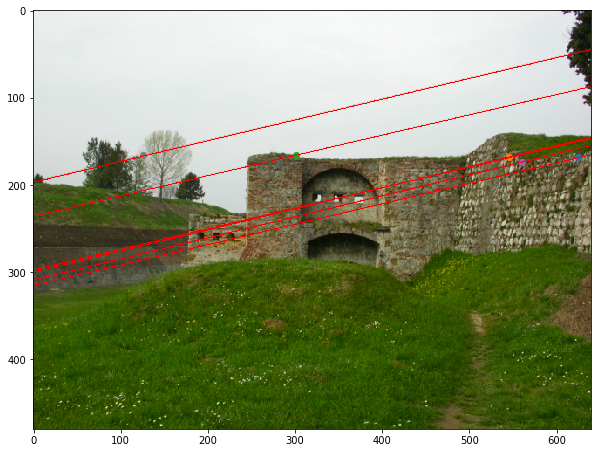

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(img2)

for i in range(8):
    plt.scatter(x=coordi[i][1][0], y=coordi[i][1][1])
    for j in range(1, 640):
        y = - (nLine[i][0]*j + nLine[i][2]) / nLine[i][1]
        plt.plot([j], [y], marker='1', markersize=1, color='red')

plt.show()

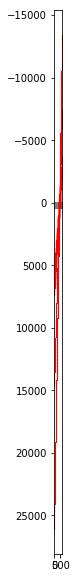

In [51]:
nLine = []

for i in range(8):
    nLine.append(np.dot(nF, np.array([[coordi[i][0][0]], [coordi[i][0][1]], [1]])))

nLine= np.array(nLine)
nLine.reshape(8, 3)

plt.figure(figsize=(10, 10))
plt.imshow(img1)

for i in range(8):
    plt.scatter(x=coordi[i][0][0], y=coordi[i][0][1])
    for j in range(1, 640):
        y = - (nLine[i][0]*j + nLine[i][2]) / nLine[i][1]
        plt.plot([j], [y], marker='1', markersize=1, color='red')

plt.show()